# JWST-ERS Clusters
## Spectral Population Synthesis Fitting

The goal of this notebook is to fit some simple JWST prism spectra with [prospector](https://github.com/bd-j/prospector).

In [1]:
import os
import time
import pickle

import nestle
import h5py
import numpy as np

In [2]:
from prospect.io import write_results
from prospect.sources import CSPSpecBasis

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
MICRON2ANG = 1e4 # micron --> Angstrom
MAGGIES2MJY = 10**(0.4 * 16.4)  # maggies --> mJy
MAGGIES2MUJY = 10**(0.4 * 23.9) # maggies --> microJy

### Define the key prospector functions.

In [5]:
def load_obs(zred=1.0, wave=None, flux=None, ferr=None, mask=None):
    """Generate the prospector-style "obs" dictionary which contains the input
    photometry, redshift, etc. for a single object.

    Args:
        zred (float): Galaxy redshift.
        wave (np.array, npix): Wavelength array (micron).
        flux (np.array, npix): Galaxy spectrum (units??).
        ferr (np.array, npix): Uncertainty spectrum corresponding to flux (units??).
        mask (np.array, npix): Mask spectrum (1=good, 0=bad).
        
    Returns:
        obs (dict): Dictionary used by prospector.

    """
    obs = {} 

    # Input photometry
    obs['filters'] = None
    obs['maggies'] = None
    obs['maggies_unc'] = None

    # Input spectroscopy
    obs['wavelength'] = wave * MICRON2ANG
    obs['spectrum'] = flux
    obs['unc'] = ferr
    obs['mask'] = mask

    # Store the redshift and any other galaxy properties
    obs['zred'] = zred

    return obs

In [6]:
def logmass2mass(logmass=11.0, **extras):
    return 10**logmass

In [7]:
def load_model(zred=1.0, seed=None):
    """Initialize the priors on each free and fixed parameter.

    Args:
      zred (float): input (fixed) galaxy redshift.

    Returns:
      sed (prospect.models.sedmodel.SedModel): SED priors and other stuff.

    Notes:
      FSPS parameters are documented here:
        http://dan.iel.fm/python-fsps/current/stellarpop_api/#api-reference

      Initialization parameters:
        * compute_vega_mags (must be set at initialization)
        * vactoair_flag (must be set at initialization)
        * zcontinuous (must be set at initialization)
    
      Metallicity parameters:
        * zmet (default 1, ignored if zcontinuous>0)
        * logzsol (default 0.0, used if zcontinuous>0)
        * pmetals (default 2.0, only used if zcontinuous=2)

      Dust parameters:
        * add_agb_dust_model (default True)
        * add_dust_emission (default True)
        * cloudy_dust (default False)
        * agb_dust (default 1.0)
        * dust_type (default 0=power law)
        * dust_index, dust1_index
        * dust_tesc
        * dust1 (default 0.0) - extra optical depth towards young stars at 5500A
        * dust2 (default 0.0) - diffuse dust optical depth towards all stars at 5500A
        * dust_clumps, frac_nodust, frac_obrun
        * mwr, uvb, wgp1, wgp2, wgp3, 
        * duste_gamma, duste_umin, duste_qpah

      Star formation history parameters:
        * sfh (default 0=SSP, 1=tau, 4=delayed, 5=truncated delayed tau)
        * tau (default 1)
        * const, sf_start, sf_trunc
        * tage (default 0.0)
        * fburst, tburst, sf_slope
    
      Miscellaneous parameters:
        * add_igm_absorption (default False)
        * igm_factor (default 1.0)
        * smooth_velocity (default True)
        * sigma_smooth, min_wave_smooth, max_wave_smooth
        * redshift_colors (default False, do not use)
        * compute_light_ages (default False, do not use)
       
      Stellar population parameters:
        * add_stellar_remnants (default True)
        * tpagb_norm_type (default 2)
        * dell (default 0.0, do not use)
        * delt (default 0.0, do not use)
        * redgb (default 1.0)
        * fcstar (default 1.0)
        * sbss (default 0.0)
        * fbhb (default 0.0)
        * pagb (default 1.0)
        * imf_type (default 2=Kroupa01)
        * imf1, imf2, imf3, vdmc, mdave, masscut
        * evtype (default 1)
        * tpagb_norm_type

      Emission lines:
        * add_neb_emission (default False)
        * add_neb_continuum (default False)
        * gas_logz (default 0.0)
        * gas_logu (default -2)

      Galaxy properties:
        * zred (default 0.0)

      AGN properties:
        * fagn (default 0.0)
        * agn_tau (default 10)

      Calibration parameters:
        * phot_jitter

    """
    from prospect.models import priors, sedmodel

    model_params = []

    ##################################################
    # Fixed priors

    # Galaxy redshift
    model_params.append({
        'name': 'zred',
        'N': 1,
        'isfree': False,
        'init': zred,
        'units': '',
        'prior': None,       
        })

    model_params.append({ # current mass in stars, not integral of SFH
        'name': 'mass_units',
        'N': 1,
        'isfree': False,
        'init': 'mstar', # 'mformed'
        'prior': None,       
        })

    # IMF (Chabrier)
    model_params.append({
        'name': 'imf_type',
        'N': 1,
        'isfree': False,
        'init':   1, # 1 - Chabrier
        'units': '',
        'prior': None,       
        })

    # SFH parameterization (delayed-tau)
    model_params.append({
        'name': 'sfh',
        'N': 1,
        'isfree': False,
        'init':   4, # 4 = delayed tau model
        'units': 'type',
        'prior': None,       
        })

    # Do not include dust emission
    model_params.append({
        'name': 'add_dust_emission',
        'N': 1,
        'isfree': False,
        'init':   False, # do not include dust emission
        'units': 'index',
        'prior': None,       
        })

    ##################################################
    # Free priors / parameters

    # Priors on stellar mass and stellar metallicity
    logmass_prior = priors.TopHat(mini=9.0, maxi=13.0)#, seed=seed)
    logmass_init = np.diff(logmass_prior.range)/2.0 + logmass_prior.range[0] # logmass_prior.sample()
    model_params.append({
        'name': 'logmass',
        'N': 1,
        'isfree': True,
        'init': logmass_init, # mass, 
        'init_disp': 0.5,     # dex
        'units': r'$M_{\odot}$',
        'prior': logmass_prior,
        })
    
    model_params.append({
        'name': 'mass',
        'N': 1,
        'isfree': False,
        'init': 10**logmass_init,
        'units': '',
        'prior': None,
        'depends_on': logmass2mass,
        })

    logzsol_prior = priors.TopHat(mini=np.log10(0.004/0.019), maxi=np.log10(0.04/0.019))#, seed=seed)
    logzsol_init = np.diff(logzsol_prior.range)/2.0 + logzsol_prior.range[0] # logzsol_prior.sample(), # logzsol,
    model_params.append({
        'name': 'logzsol',
        'N': 1,
        'isfree': True,
        'init': logzsol_init,
        'init_disp': 0.3, # logzsol_prior.range[1] * 0.1,
        'units': r'$\log_{10}\, (Z/Z_\odot)$',
        'prior': logzsol_prior, # roughly (0.2-2)*Z_sun
        })

    # Prior(s) on dust content
    dust2_prior = priors.TopHat(mini=0.0, maxi=3.0)#, seed=seed)
    dust2_init = np.diff(dust2_prior.range)/2.0 + dust2_prior.range[0] # dust2_prior.sample(), # dust2,
    model_params.append({
        'name': 'dust2',
        'N': 1,
        'isfree': True,
        'init': dust2_init,
        'init_disp': 0.5, # dust2_prior.range[1] * 0.1,
        'units': '', # optical depth
        'prior': dust2_prior,
        })
    
    # Priors on tau and age
    #tau_prior = priors.TopHat(mini=0.1, maxi=10.0)#, seed=seed)
    tau_prior = priors.LogUniform(mini=0.1, maxi=10.0)#, seed=seed)
    tau_init = np.diff(tau_prior.range)/2.0 + tau_prior.range[0] # tau_prior.sample(), # tau,
    model_params.append({
        'name': 'tau',
        'N': 1,
        'isfree': True,
        'init': tau_init,
        'init_disp': 1.0, # tau_prior.range[1] * 0.1,
        'units': 'Gyr',
        'prior': tau_prior,
        })

    tage_prior = priors.TopHat(mini=1.0, maxi=5.0)#, seed=seed)
    tage_init = np.diff(tage_prior.range) / 2.0 + tage_prior.range[0] # tage_prior.sample(), # tage,
    model_params.append( {
        'name': 'tage',
        'N': 1,
        'isfree': True,
        'init': tage_init,
        'init_disp': 2.0, # tage_prior.range[1] * 0.1,
        'units': 'Gyr',
        'prior': tage_prior,
        })

    model = sedmodel.SedModel(model_params)
    
    return model

In [8]:
def lnprobfn(theta, spec_noise=None, phot_noise=None, verbose=False):
    """Define the likelihood function.

    Given a parameter vector and a dictionary of observational data and a model
    object, return the ln of the posterior. This requires that an sps object
    (and if using spectra and gaussian processes, a GP object) be instantiated.

    """
    from prospect.likelihood import lnlike_spec, lnlike_phot, chi_spec, chi_phot
    
    lnp_prior = model.prior_product(theta, nested=True)
    if np.isfinite(lnp_prior):
        # Generate the mean model--
        t1 = time.time()
        try:
            model_spec, model_phot, model_extras = model.mean_model(theta, obs, sps=sps)
            mu, phot, x = model.mean_model(theta, obs, sps=sps)
        except(ValueError):
            return -np.infty
        d1 = time.time() - t1

        # Noise modeling--
        if spec_noise:
            spec_noise.update(**model.params)
        if phot_noise:
            phot_noise.update(**model.params)

        vectors = {
            'spec': model_spec,    # model spectrum
            'phot': model_phot,    # model photometry
            'sed': model._spec,    # object spectrum
            'cal': model._speccal, # object calibration spectrum
        }

        # Calculate likelihoods--
        t2 = time.time()
        lnp_spec = lnlike_spec(model_spec, obs=obs, spec_noise=spec_noise, **vectors)
        lnp_phot = lnlike_phot(model_phot, obs=obs, phot_noise=phot_noise, **vectors)
        d2 = time.time() - t2
        if verbose:
            from prospect.likelihood import write_log
            write_log(theta, lnp_prior, lnp_spec, lnp_phot, d1, d2)

        return lnp_prior + lnp_phot + lnp_spec
    else:
        return -np.infty

In [9]:
def load_run_params(prefix, seed=None):
    """Populate the run_params dictionary."""
    run_params = {
        'prefix':  prefix,
        'verbose': True,
        'seed':    seed,
        # Nestle fitting parameters
        'nestle_method': 'single',
        'nestle_npoints': 100,
        'nestle_maxcall': int(1e6),
        # Smoothing model
        'smoothtype': 'R', # constant resolution (other options are "vel", "sigma", etc.)
        'resolution': 500.0, # is this right??
        # SPS initialization parameters
        'compute_vega_mags': False,
        'vactoair_flag': False, # use wavelengths in air
        'zcontinuous': 1,      # interpolate in metallicity
    }
    return run_params

### Read the set of galaxy spectra to fit.

In [10]:
def read_jwst(prefix='jwst'):
    """Read a simulated JWST spectrum.  
    
    Args:
       prefix (str): Prefix of the spectral file on-disk.
       
    Returns:

    """
    import fitsio

    zred = 1.5 # hard-coded!
    ABmagnorm = 10**(-0.4 * 23.0) # hard-coded normalization factor!
    
    fitsflux = fitsio.read(os.path.join(jwstdir, '{}_extracted_flux.fits'.format(prefix)), ext=1, upper=True)
    fitsferr = fitsio.read(os.path.join(jwstdir, '{}_extracted_noise.fits'.format(prefix)), ext=1, upper=True)
    
    wave = fitsflux['WAVELENGTH']
    flux = fitsflux['EXTRACTED_FLUX'] * ABmagnorm
    ferr = fitsferr['EXTRACTED_NOISE'] * ABmagnorm

    return wave, flux, ferr, zred

In [11]:
seed = 123
rand = np.random.RandomState(seed)

prefix = 'lineplot'
jwstdir = os.path.join( os.getenv('IM_PROJECTS_DIR'), 'jwstclusters' )
outroot = os.path.join( jwstdir, '{}_prospect'.format(prefix) )
hfilename = os.path.join( jwstdir, '{}_prospect_mcmc.h5'.format(prefix) )

In [12]:
run_params = load_run_params(prefix, seed=seed)

In [13]:
wave, flux, ferr, zred = read_jwst(prefix)

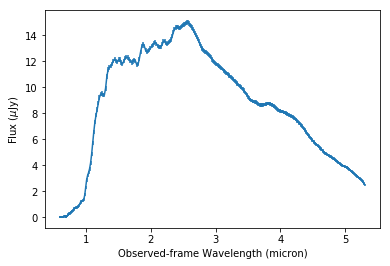

In [14]:
fig, ax = plt.subplots()
ax.errorbar(wave, flux * MAGGIES2MUJY, ferr * MAGGIES2MUJY)
ax.set_xlabel('Observed-frame Wavelength (micron)')
ax.set_ylabel('Flux ($\mu$Jy)')

### Initialize the SSPs.

In [15]:
t0 = time.time()
print('Initializing CSPSpecBasis...')
sps = CSPSpecBasis(zcontinuous=run_params['zcontinuous'],
                   compute_vega_mags=run_params['compute_vega_mags'],
                   vactoair_flag=run_params['vactoair_flag'])
print('...took {:.1f} seconds.'.format(time.time() - t0)) 

Initializing CSPSpecBasis...
...took 11.3 seconds.


### Do the fitting and write out.

In [16]:
obs = load_obs(zred=zred, wave=wave, flux=flux, ferr=ferr)
obs.keys()

dict_keys(['filters', 'maggies', 'maggies_unc', 'wavelength', 'spectrum', 'unc', 'mask', 'zred'])

In [17]:
model = load_model(zred=obs['zred'], seed=run_params['seed'])

In [18]:
print('Starting nestle at {}'.format(time.asctime()))
tstart = time.time()
nestleout = nestle.sample(lnprobfn, model.prior_transform, model.ndim, rstate=rand,
                          callback=None, pool=None, 
                          method=run_params['nestle_method'],
                          npoints=run_params['nestle_npoints'],
                          maxcall=run_params['nestle_maxcall'])
dur = time.time() - tstart
print('Nestle took {:.2f} minutes'.format(dur / 60.0))

Starting nestle at Thu Jul 27 14:32:26 2017
Nestle took 4.46 minutes


In [19]:
# Write the nestle results to an HDF5 file and the model as a pickle file.
print('Opening HDF5 output file {}'.format(hfilename))
hfile = h5py.File(hfilename, 'a')
write_results.write_h5_header(hfile, run_params, model)
write_results.write_obs_to_h5(hfile, obs)
#write_results.write_hdf5(hfilename, run_params, model, obs, nestleout, None, tsample=dur)

#with open('{}_nmc.pkl'.format(outroot), 'w') as f:
#    pickle.dump(nestleout, f)
partext = write_results.paramfile_string(**run_params)
write_results.write_model_pickle('{}_model'.format(outroot), model, paramfile_text=partext)
hfile.close()

Opening HDF5 output file /Users/ioannis/research/projects/jwstclusters/lineplot_prospect_mcmc.h5
Could not JSON serialize model_params, pickled instead


### Generate QAplots.

In [20]:
def _niceparnames(parnames):
    """Replace parameter names with nice names."""

    old = list(['tau',
           'tage',
           'mass',
           'logmass',
           'logzsol',
           'dust2'])
    new = list([r'$\tau$ (Gyr)',
           'Age (Gyr)',
           r'$M / M_{\odot}$',
           r'$\log_{10}\,(M / M_{\odot})$',
           r'$\log_{10}\, (Z / Z_{\odot})$',
           r'$\tau_{diffuse}$'])

    niceparnames = list(parnames).copy()
    for oo, nn in zip( old, new ):
        this = np.where(np.in1d(parnames, oo))[0]
        if len(this) > 0:
            niceparnames[this[0]] = nn
            
    return np.array(niceparnames)

In [21]:
def _galaxysed(obs):
    """Generate the galaxy SED, converting from Angstroms to microns 
    and from maggies to mJy.

    """
    galaxywave = obs['wavelength'] / MICRON2ANG # [micron]
    galaxyspec = obs['spectrum'] * MAGGIES2MUJY
    galaxyuncspec = obs['unc'] * MAGGIES2MUJY
    
    return galaxywave, galaxyspec, galaxyuncspec

In [22]:
def _modelsed(model, theta, obs, sps):
    """Construct a model SED for a given set of parameters, converting
    from Angstroms to microns and from maggies to mJy.

    """
    modelwave = sps.csp.wavelengths * (1 + obs['zred']) # [observed-frame wavelengths]
    modelwave /= MICRON2ANG # [micron]
    
    modelspec, modelphot, mextra = model.mean_model(theta, obs, sps=sps)
    modelspec *= MAGGIES2MUJY
    
    return modelwave, modelspec, modelphot

In [23]:
def bestfit_sed(obs, samples=None, logl=None, theta=None, sps=None,
                model=None, seed=None, nrand=100):
    """Plot the data and the best-fitting SED model.

    Either pass samples and logl (to visualize samples from the posterior)
    *or* theta (to visualize just a single SED fit).
    
    logl - ln(likelihood)

    """
    rand = np.random.RandomState(seed)

    # Build the galaxy spectrum.
    galaxywave, galaxyspec, galaxyuncspec = _galaxysed(obs)
    
    # Build the maximum likelihood model fit and also grab a random sampling of
    # the samples with weight equal to the posterior probability.    
    if samples is not None:
        nsamples, nparams = samples.shape
        theta = samples[logl.argmax(), :] # maximum likelihood values

        prob = np.exp(logl - logl.max())
        prob /= prob.sum()
        rand_indx = rand.choice(nsamples, size=nrand, replace=False)#, p=prob)
        theta_rand = samples[rand_indx, :]
        
    modelwave, modelspec, _ = _modelsed(model=model, theta=theta, obs=obs, sps=sps)
    print(modelwave.shape, modelspec.shape)

    # Establish the wavelength and flux limits.
    #minwave, maxwave = 0.1, 6.0
    minwave, maxwave = np.min(galaxywave), np.max(galaxywave)

    inrange = (modelwave > minwave) * (modelwave < maxwave)
    #print(modelwave.min(), modelwave.max(), minwave, maxwave)
    #maxflux = np.hstack( (galaxyspec, modelspec[inrange]) ).max() * 1.05
    maxflux = np.hstack( (galaxyspec, modelspec) ).max() * 1.05
    minflux = -0.05 * maxflux

    fig, ax = plt.subplots(figsize=(12, 8))
    if samples is not None:
        for ii in range(nrand):
            _, r_modelspec, _ = _modelsed(model=model, theta=theta_rand[ii, :], obs=obs, sps=sps)
            ax.plot(galaxywave, r_modelspec, alpha=0.2, color='gray')
    ax.plot(galaxywave, modelspec, alpha=1.0, label='Model spectrum')
    #ax.plot(modelwave, modelspec, alpha=1.0, label='Model spectrum')

    ax.errorbar(galaxywave, galaxyspec, galaxyuncspec, alpha=0.8, 
                label='Observed Spectrum')
                
    ax.set_xlabel(r'Observed-Frame Wavelength (${}$m)'.format('\mu'))
    ax.set_ylabel('Flux Density ($\mu$Jy)')
    ax.set_xlim(minwave, maxwave)
    ax.set_ylim(minflux, maxflux)
    ax.legend(loc='upper right', fontsize=16, frameon=False)
    fig.subplots_adjust(left=0.1, right=0.95, bottom=0.12, top=0.95)

    return fig

(5994,) (403,)


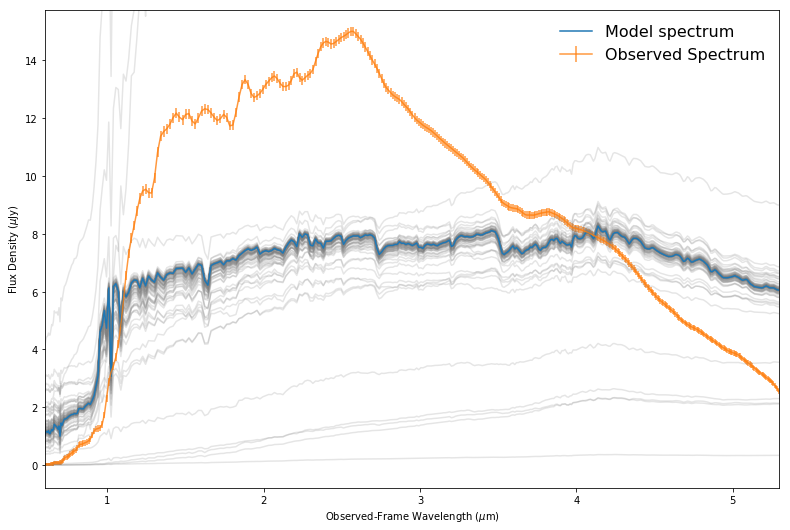

In [24]:
fig = bestfit_sed(obs, samples=nestleout['samples'], logl=nestleout['logl'], 
                  sps=sps, model=model, seed=run_params['seed'])    